<a href="https://colab.research.google.com/github/robitussin/CCDEPLRL_EXERCISES/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7

Text Generation using LSTM

In [80]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, LayerNormalization # Import LayerNormalization here
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
from keras.regularizers import l2
import matplotlib.pyplot as plt

In [81]:
tokenizer = Tokenizer()

!wget --no-check-certificate \
    https://raw.githubusercontent.com/cibernox/storyteller/refs/heads/master/snow-white.txt \
    -O /tmp/snowwhite.txt

data = open('/tmp/snowwhite.txt').read()

--2025-05-27 09:19:47--  https://raw.githubusercontent.com/cibernox/storyteller/refs/heads/master/snow-white.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520 (1.5K) [text/plain]
Saving to: ‘/tmp/snowwhite.txt’

/tmp/snowwhite.txt  100%[===================>]   1.48K  --.-KB/s    in 0s      

2025-05-27 09:19:47 (32.5 MB/s) - ‘/tmp/snowwhite.txt’ saved [1520/1520]



In [82]:
corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

## Create the LSTM model

1. Build an LSTM

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define model
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=64, input_length=max_sequence_len-1))  # Reduced dim for regularization
model.add(Dropout(0.25))  # Dropout before LSTM
model.add(Bidirectional(LSTM(128, return_sequences=False, recurrent_dropout=0.3)))  # Reduced units + recurrent dropout
model.add(Dropout(0.15))
model.add(LayerNormalization())
model.add(Dense(total_words, activation='softmax', kernel_regularizer=l2(0.001)))  # L2 regularization to reduce overfitting

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("textgen_model.h5", monitor='loss', save_best_only=True)

model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_11               │ ?                           │     0 (unbuilt) │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [84]:
# Train model
history = model.fit(predictors, label, epochs=100, callbacks=[early_stop, model_checkpoint])


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.0113 - loss: 5.2870

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.0118 - loss: 5.2805
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0565 - loss: 4.8837

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.0570 - loss: 4.8780
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.0944 - loss: 4.7041

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.0939 - loss: 4.7032
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0756 - loss: 4.6770

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.0781 - loss: 4.6653
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.1073 - loss: 4.3567

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.1071 - loss: 4.3635
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.1234 - loss: 4.2651

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.1228 - loss: 4.2639
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1645 - loss: 4.0874

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.1671 - loss: 4.0825
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.1979 - loss: 3.9418

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.1995 - loss: 3.9315
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2206 - loss: 3.6386

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.2219 - loss: 3.6333
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2700 - loss: 3.4193

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.2691 - loss: 3.4129
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2657 - loss: 3.1194

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.2661 - loss: 3.1174
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3494 - loss: 2.9103

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.3496 - loss: 2.9052
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4583 - loss: 2.5418

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4559 - loss: 2.5464
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4855 - loss: 2.3811

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4842 - loss: 2.3835
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5013 - loss: 2.1320

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5004 - loss: 2.1340
Epoch 16/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5306 - loss: 2.0252

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5329 - loss: 2.0242
Epoch 17/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6487 - loss: 1.7866

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6429 - loss: 1.7953
Epoch 18/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6321 - loss: 1.6903

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.6317 - loss: 1.6950
Epoch 19/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6705 - loss: 1.5648

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.6704 - loss: 1.5689
Epoch 20/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7407 - loss: 1.4435

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7387 - loss: 1.4441
Epoch 21/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7182 - loss: 1.3787

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7196 - loss: 1.3766
Epoch 22/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7848 - loss: 1.2889

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7838 - loss: 1.2889
Epoch 23/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7796 - loss: 1.1456

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7805 - loss: 1.1471
Epoch 24/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8437 - loss: 1.1352

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8416 - loss: 1.1351
Epoch 25/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8296 - loss: 1.0688

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8277 - loss: 1.0695
Epoch 26/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8426 - loss: 1.0177

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8442 - loss: 1.0180
Epoch 27/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8670 - loss: 0.9462

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8668 - loss: 0.9479
Epoch 28/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9381 - loss: 0.8295

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9350 - loss: 0.8331
Epoch 29/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9108 - loss: 0.8218

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9112 - loss: 0.8237
Epoch 30/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9195 - loss: 0.7077

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9185 - loss: 0.7140
Epoch 31/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9182 - loss: 0.7068

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9168 - loss: 0.7093
Epoch 32/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9102 - loss: 0.6819

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9089 - loss: 0.6852
Epoch 33/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9622 - loss: 0.6358

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9610 - loss: 0.6367
Epoch 34/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9585 - loss: 0.6320
Epoch 35/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9676 - loss: 0.5867

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9663 - loss: 0.5913
Epoch 36/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9530 - loss: 0.5702

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.9510 - loss: 0.5723
Epoch 37/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9606 - loss: 0.5688

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9586 - loss: 0.5708
Epoch 38/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9529 - loss: 0.5349

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9527 - loss: 0.5367
Epoch 39/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9172 - loss: 0.6013
Epoch 40/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9654 - loss: 0.5163

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9642 - loss: 0.5176
Epoch 41/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9700 - loss: 0.5447
Epoch 42/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9630 - loss: 0.4819

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9630 - loss: 0.4844
Epoch 43/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9619 - loss: 0.4709

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9612 - loss: 0.4706
Epoch 44/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9722 - loss: 0.4548

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9712 - loss: 0.4551
Epoch 45/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9698 - loss: 0.4802
Epoch 46/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9581 - loss: 0.4608

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9577 - loss: 0.4600
Epoch 47/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9661 - loss: 0.4376
Epoch 48/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9697 - loss: 0.4378

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9690 - loss: 0.4378
Epoch 49/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9710 - loss: 0.4194
Epoch 50/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9792 - loss: 0.4443
Epoch 51/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9651 - loss: 0.4154

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9649 - loss: 0.4175
Epoch 52/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9736 - loss: 0.4126
Epoch 53/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9614 - loss: 0.4218

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9620 - loss: 0.4216
Epoch 54/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9765 - loss: 0.3750

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9750 - loss: 0.3773
Epoch 55/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9745 - loss: 0.3901

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9742 - loss: 0.3903
Epoch 56/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9623 - loss: 0.3825

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9629 - loss: 0.3827
Epoch 57/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9649 - loss: 0.3805
Epoch 58/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9930 - loss: 0.3616

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9920 - loss: 0.3625
Epoch 59/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9829 - loss: 0.3621
Epoch 60/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9474 - loss: 0.4092
Epoch 61/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9738 - loss: 0.3378

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9736 - loss: 0.3385
Epoch 62/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9756 - loss: 0.3837
Epoch 63/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9595 - loss: 0.3610
Epoch 64/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9637 - loss: 0.3406


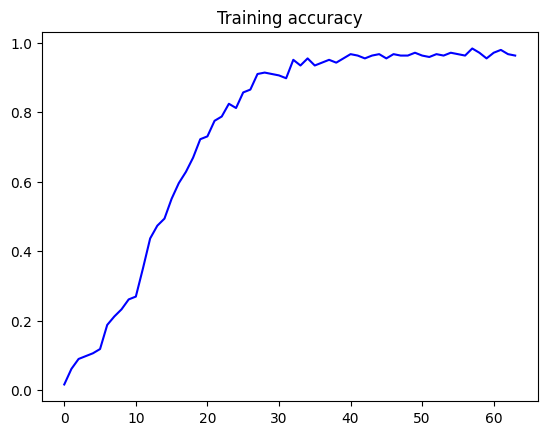

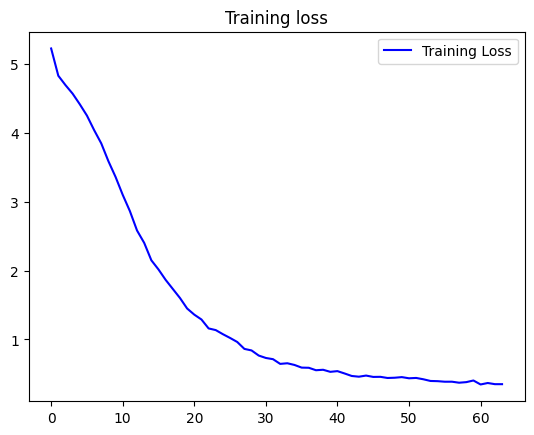

In [85]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

## B. Generate texts


2. "Snow White lived in the forest with..."

In [86]:
seed_text = "Snow White lived in the forest with"
next_words = 20

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Snow White lived in the forest with began to cry cry cry cry cry her calling one one one and she heard it say say the forest


3. "The queen looked into the mirror and said..."

In [87]:

seed_text = "The queen looked into the mirror and said"
next_words = 20

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
The queen looked into the mirror and said leaving snow white was all alone in the forest began to cry cry cry cry cry her and she heard


4. "One day, Snow White found a small cottage and..."

In [88]:

seed_text = "One day, Snow White found a small cottage and"
next_words = 20
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
One day, Snow White found a small cottage and she heard the forest far away however when they came to the fatal spot spot spot spot spot return and


In [89]:

seed_text = "Snow White is"
next_words = 20

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Snow White is the loveliest in the land land land land land to reward to take snow white intc the forest far away
